<a href="https://colab.research.google.com/github/Dasrunaik/Custom-Sentiment-Analysis-using-BERT/blob/main/HuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
df=messages=pd.read_csv('/content/SMSSpamCollection.txt',sep='\t',names=['label','message'])

In [3]:
df.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df.columns

Index(['label', 'message'], dtype='object')

In [5]:
df.shape

(5572, 2)

In [6]:
df["label"].value_counts()

,count
label,
ham,4825
spam,747


In [7]:
df.isnull().sum()

,0
label,0
message,0


In [8]:
df.duplicated().sum()

np.int64(403)

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

np.int64(0)

In [11]:
df.describe()

,label,message
count,5169,5169
unique,2,5169
top,ham,Rofl. Its true to its name
freq,4516,1


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

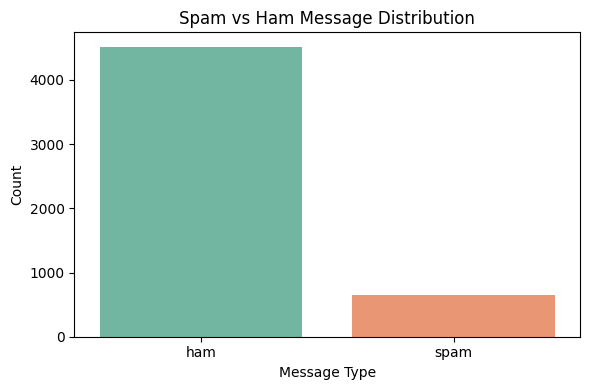

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, hue='label', palette='Set2', legend=False)
plt.title('Spam vs Ham Message Distribution')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("spam_vs_ham_distribution.png")  # or use plt.show() in notebooks


In [14]:
df['labels']=df['label'].apply(lambda x: 1 if x=='spam' else 0)

In [15]:
df.head(10)

,label,message,labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


In [16]:
X=list(df['message'])


In [17]:
y=list(df['labels'])

Train and Test Split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

Using the the bert transformers

In [19]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Encoding

In [20]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer((X_test), truncation=True, padding=True)

In [21]:
import torch
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(y_train))

In [22]:
class SentientDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [23]:
train_dataset = SentientDataset(train_encodings, list(y_train))
test_dataset = SentientDataset(test_encodings, list(y_test))

Pretraind and Fine tuning

In [24]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

In [25]:
model=DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [27]:
training_args=TrainingArguments(output_dir='./results',
                                num_train_epochs=2,
                                learning_rate=2e-5,
                                per_device_train_batch_size=8,
                                per_device_eval_batch_size=8,
                                weight_decay=0.01,
                                logging_dir='./logs',
                                logging_steps=10,)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [28]:
trainer=Trainer(model=model,args=training_args,train_dataset=train_dataset,eval_dataset=test_dataset)

In [29]:
trainer.train()

Step,Training Loss
10,0.607000
20,0.378300
30,0.242400
40,0.096200
50,0.038200
60,0.016800
70,0.071300
80,0.008900
90,0.086300
100,0.111500


TrainOutput(global_step=1034, training_loss=0.056783834045592556, metrics={'train_runtime': 190.1165, 'train_samples_per_second': 43.5, 'train_steps_per_second': 5.439, 'total_flos': 472864629885960.0, 'train_loss': 0.056783834045592556, 'epoch': 2.0})

In [30]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.014663455076515675,
 'eval_runtime': 6.3916,
 'eval_samples_per_second': 161.774,
 'eval_steps_per_second': 20.339,
 'epoch': 2.0}

Prediction

In [31]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[ 3.6742594, -4.183036 ],
       [ 3.6831636, -4.124526 ],
       [ 3.5077727, -3.9169717],
       ...,
       [ 3.5414596, -3.98693  ],
       [ 3.4779851, -3.990697 ],
       [ 3.2292993, -3.7267032]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'test_loss': 0.014663455076515675, 'test_runtime': 6.4457, 'test_samples_per_second': 160.416, 'test_steps_per_second': 20.168})

In [32]:
trainer.predict(test_dataset)[1].shape

(1034,)

In [33]:
output=trainer.predict(test_dataset)[1]

In [34]:
output

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
from sklearn.metrics import confusion_matrix,classification_report

In [36]:
cm=confusion_matrix(y_test,output)
cm

array([[896,   0],
       [  0, 138]])

In [37]:
cr=classification_report(y_test,output)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       896
           1       1.00      1.00      1.00       138

    accuracy                           1.00      1034
   macro avg       1.00      1.00      1.00      1034
weighted avg       1.00      1.00      1.00      1034



Model Saved

In [38]:
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")

('saved_distilbert_model/tokenizer_config.json',
 'saved_distilbert_model/special_tokens_map.json',
 'saved_distilbert_model/vocab.txt',
 'saved_distilbert_model/added_tokens.json',
 'saved_distilbert_model/tokenizer.json')

App Running

In [39]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 128.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.8 MB/s eta 0:00:00


Streamlit deployment

In [40]:
MODEL_NAME='distilbert-base-uncased'
tokenizer=DistilBertTokenizer.from_pretrained(MODEL_NAME)
model=DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


converting the saved_model to ZIP for future

In [41]:
!zip -r saved_distilbert_model.zip saved_distilbert_model/


  adding: saved_distilbert_model/ (stored 0%)
  adding: saved_distilbert_model/tokenizer.json (deflated 71%)
  adding: saved_distilbert_model/special_tokens_map.json (deflated 42%)
  adding: saved_distilbert_model/vocab.txt (deflated 53%)
  adding: saved_distilbert_model/tokenizer_config.json (deflated 75%)
  adding: saved_distilbert_model/config.json (deflated 45%)
  adding: saved_distilbert_model/model.safetensors (deflated 8%)


In [42]:
model.save_pretrained("saved_distilbert_model")
tokenizer.save_pretrained("saved_distilbert_model")


('saved_distilbert_model/tokenizer_config.json',
 'saved_distilbert_model/special_tokens_map.json',
 'saved_distilbert_model/vocab.txt',
 'saved_distilbert_model/added_tokens.json')

Streamlit

In [43]:
%%writefile app.py
import streamlit as st
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

st.set_page_config(page_title="Spam Detector with DistilBERT", layout="centered")
st.title("SMS Spam Detection using Hugging Face DistilBERT")
st.markdown("Enter an SMS message to classify it as **Spam** or **Ham (Not Spam)**.")

# Load your saved model
MODEL_PATH = "saved_distilbert_model"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)

# Input box
text = st.text_area(" Enter a message:", height=100)

# Predict
if st.button(" Classify"):
    if not text.strip():
        st.warning("Please enter a valid message.")
    else:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            prediction = torch.argmax(logits, dim=1).item()
        if prediction == 1:
            st.error("This message is classified as **Spam**.")
        else:
            st.success(" This message is classified as **Ham (Not Spam)**.")


Writing app.py


In [76]:

!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8503
  Network URL: http://172.28.0.12:8503
  External URL: http://34.143.188.208:8503

  Stopping...
^C


In [79]:
!ps -ef | grep streamlit


root        9058     327  0 06:17 ?        00:00:00 /bin/bash -c ps -ef | grep streamlit
root        9060    9058  0 06:17 ?        00:00:00 grep streamlit


In [80]:
!pkill -f streamlit
!pkill -f ngrok


In [56]:
!ps -ef | grep -E "streamlit|ngrok"


root        3789     327  0 05:57 ?        00:00:00 /bin/bash -c ps -ef | grep -E "streamlit|ngrok"
root        3791    3789  0 05:57 ?        00:00:00 grep -E streamlit|ngrok


In [81]:
!pip install pyngrok


In [82]:
!rm -f /root/.ngrok2/ngrok.yml /root/.config/ngrok/ngrok.yml


In [83]:
!mkdir -p /root/.config/ngrok && echo "authtoken: 2ze2GNzXW2d1ZrwcUv7k4UAmEvt_6BS6v3Mh5ncGGJ2rNT56a" > /root/.config/ngrok/ngrok.yml


In [84]:
!cat /root/.config/ngrok/ngrok.yml


authtoken: 2ze2GNzXW2d1ZrwcUv7k4UAmEvt_6BS6v3Mh5ncGGJ2rNT56a


In [85]:
from pyngrok import ngrok

# Create tunnel to Streamlit port 8501
public_url = ngrok.connect(port=8501)
print(f"🌐 Your Streamlit app is live at: {public_url}")


PyngrokNgrokError: The ngrok process was unable to start.